# Image Segmentation by Clusters

## Segmentation by K-means++

In [ ]:
import numpy as np
import cv2
import os

def read_images(path):

  # initialize lists for images
  flatten_images = []
  grayscale_images = []

  for filename in os.listdir(path):

    # read image
    img = cv2.imread(os.path.join(path,filename))

    if img is not None:

      # converge to grayscale
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      grayscale_images.append(gray)

      # flatten images and convert from byte
      flatten_images.append(gray.flatten().astype(np.float32))

  return flatten_images, grayscale_images


path = "images/"
flatten_images, grayscale_images = read_images(path)

In [ ]:
def visualize(grayscale, segmented):
  for i in range(len(grayscale)):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(grayscale[i], cmap='gray')
    axs[0].set_title('Original')
    axs[1].imshow(segmented[i])
    axs[1].set_title('Segmented')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

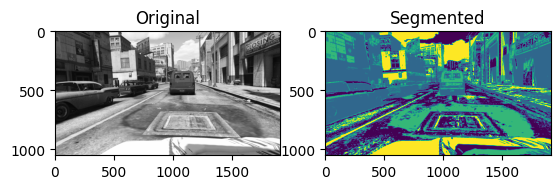

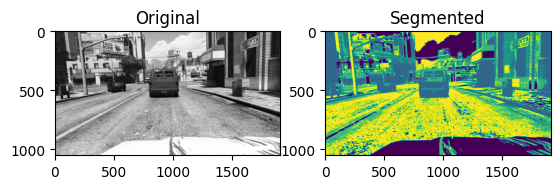

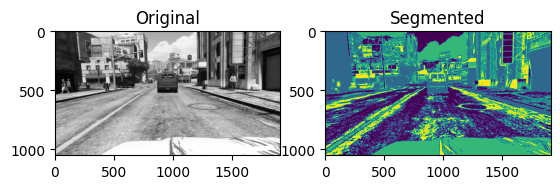

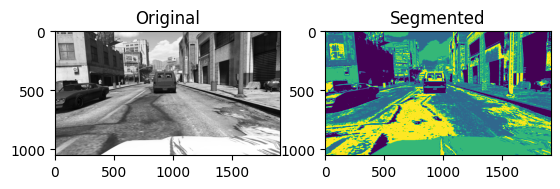

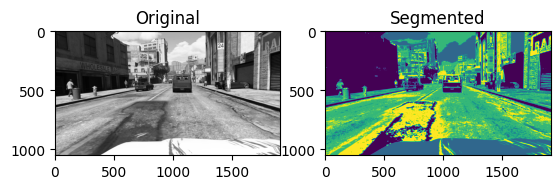

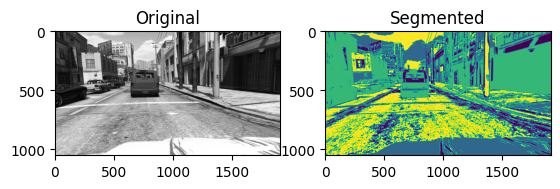

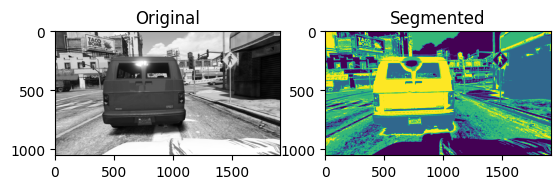

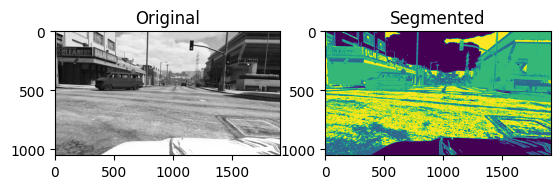

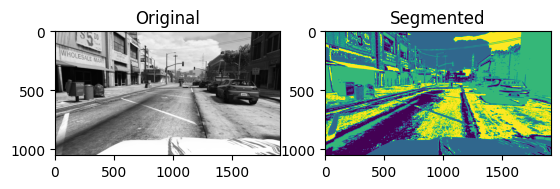

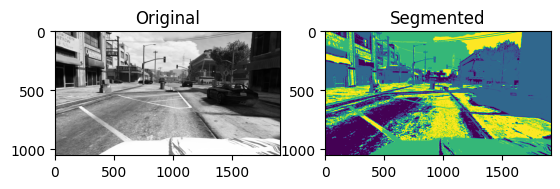

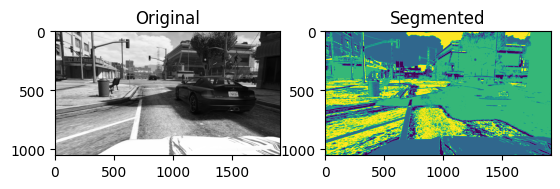

In [ ]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


def kmeans_segmentation(image, n_clusters):
  pixels = np.reshape(image, (-1, 1))

  # perform K-means clustering with KMeans from sklearn
  kmeans = KMeans(n_clusters=n_clusters, random_state=121).fit(pixels)

  # reshape the labels back to the shape of the original image
  segmented_image = np.reshape(kmeans.labels_, image.shape)

  # somehow I cannot change the color, because then the list with these colored images becomes 3D and then do not comparing with original labels


  #colors = [(224,102,102), (255,217,102), (147,196,125), (111,168,220)]

  #colored_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
  #for i in range(n_clusters):
  #  colored_image[segmented_image == i] = colors[i]

  return segmented_image


n_clusters = 4
segmented_images_kmeans = []
# apply kmeans segmentation for each image
for image in grayscale_images:
  segmented_images_kmeans.append(kmeans_segmentation(image, n_clusters))


# visualization
visualize(grayscale_images, segmented_images_kmeans)

## Segmentation by Fuzzy Clustering

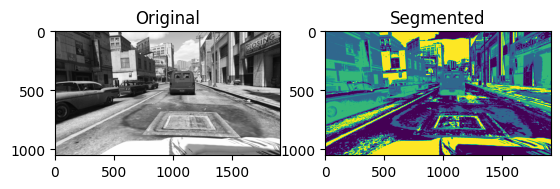

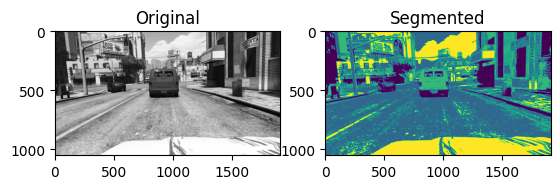

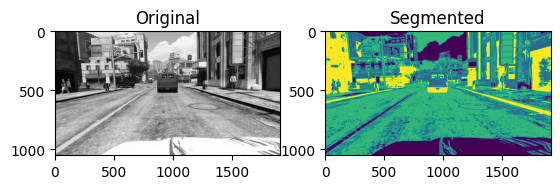

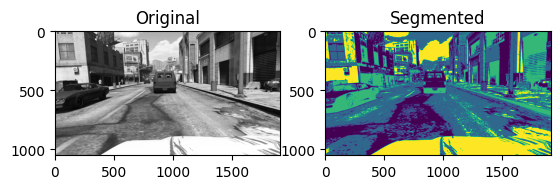

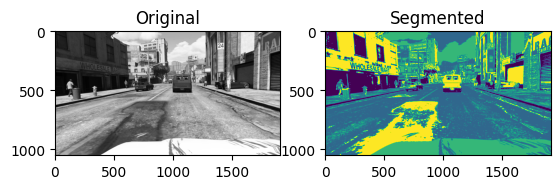

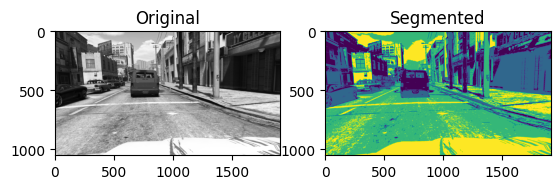

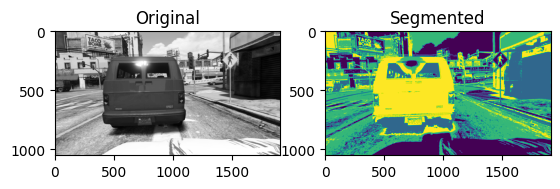

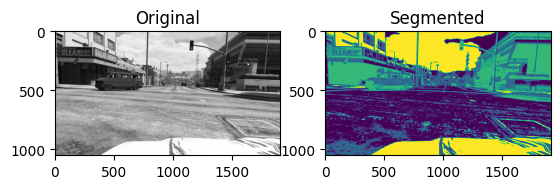

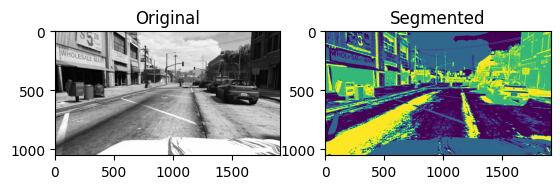

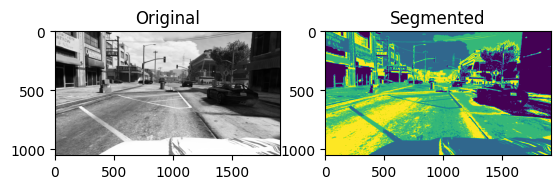

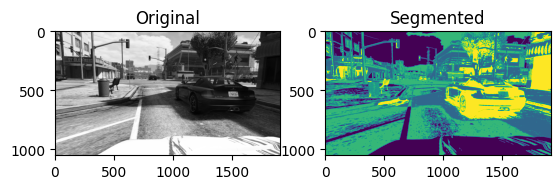

In [ ]:
import numpy as np
import math
import cv2

class MyClusteringAlg():

    # Constructor with common parameters
    # n_clusters - number of clusters (recommended from 3 to 7)
    # m          - FCM hyperparameter to contol the spray of the clusters (recommended from 2 to 5)
    # epsilon    - stop factor, the minimum possible distance (Euclidian or Manhattan) between
    #              membership matricies after and before update
    # max_iter   - stop factor, maximum possible iteration in segmentImage()
    def __init__(self, n_clusters = 4, m = 5, epsilon = 0.1, max_iter = 100):
        self.n_clusters = n_clusters
        self.m = m
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.W = None
        self.centroids = None

    # initialize membership matrix
    def __initW(self, n_pixels):
        w = np.random.rand(n_pixels, self.n_clusters)
        self.W = w / np.sum(w, axis=1)[:, None]

    # calculate membership matrix
    def __updateWeightMat(self, pixels):
        distances = np.abs(pixels[:, None] - self.centroids[None, :])
        new_W = 1 / (distances / np.expand_dims(np.abs(self.centroids), axis=0)**(2/(self.m-1)) + self.epsilon)
        return new_W / np.sum(new_W, axis=1)[:, None]

    # calculate centroids
    def __updateClusterCentroids(self, pixels):
        for j in range(self.n_clusters):
            self.centroids[j] = np.sum(self.W[:, j]**self.m * pixels) / np.sum(self.W[:, j]**self.m)


    # inputs the original grayscale image, returns its segmented version
    def segmentImage(self, image:np.array)->np.array:

        pixels = image.flatten()
        self.__initW(pixels.shape[0])
        self.centroids = np.random.rand(self.n_clusters) * 255

        # iterate for max_iter
        for i in range(self.max_iter):

            new_W = self.__updateWeightMat(pixels)
            self.__updateClusterCentroids(pixels)

            # break if distance is less than epsilon
            if np.max(np.abs(new_W - self.W)) < self.epsilon:
                break

            self.W = new_W

        # reshape to the original image
        segmented_image = np.reshape(np.argmax(self.W, axis=1), image.shape)
        return segmented_image

my_clustering_alg = MyClusteringAlg(n_clusters=4)
segmented_images_cmeans = []
for image in grayscale_images:
    segmented_images_cmeans.append(my_clustering_alg.segmentImage(image))

# visualization
visualize(grayscale_images, segmented_images_cmeans)

### Сompare the performance

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# load the ground truth images
gt_images = []

gt_dir = "labels/"
for filename in os.listdir(gt_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        gt_images.append(cv2.imread(os.path.join(gt_dir, filename), cv2.IMREAD_GRAYSCALE))

# calculate the similarities
kmeans_similarities = []
cmeans_similarities = []
for i in range(len(gt_images)):
    for j in range(len(segmented_images_kmeans)):
        kmeans_similarities.append(np.mean(np.abs(cosine_similarity(gt_images[i], segmented_images_kmeans[j]))))
        cmeans_similarities.append(np.mean(np.abs(cosine_similarity(gt_images[i], segmented_images_cmeans[j]))))

# print the result
print('Average similarity for K-means: {:.4f}'.format(np.mean(kmeans_similarities)))
print('Average similarity for C-means: {:.4f}'.format(np.mean(cmeans_similarities)))

Average similarity for K-means: 0.7112
Average similarity for C-means: 0.7034


### References

https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081

https://en.wikipedia.org/wiki/Fuzzy_clustering